In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Try different beta-binom coef from notebook 0

In [2]:
from scipy.special import expit
rho1 = expit(-9.19) # the inverse of logit. these numbers are from notebook 0
rho2=  expit(-1.15)
rho3 = expit(-3.24)

In [3]:
def get_alpha_beta(mu, rho):
    ''' rho and mu can be reparameterized into alpha and beta
    just because this is what python takes '''
    #https://dcgerard.github.io/updog/reference/betabinom.html
    
    alpha = mu*(1-rho)/rho
    beta=(1-mu)*(1-rho)/rho
    
    return alpha, beta
    

# Plot the variablility between 2 reps

In [4]:
counts = pd.read_csv('/home/hsher/scratch/rar11_input.tsv', sep = '\t')
counts.shape

(125726, 25)

In [5]:
rep1='PP_Input1'
rep2='PP_Input2'
r1_handle = f'BSJ-{rep1}'
r2_handle = f'BSJ-{rep2}'


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from scipy.stats import betabinom
from scipy.stats import poisson

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)

# estimate mu, From maximum likelihood estimation we know mu is just the 
#(total counts in rep1)/(total counts in both reps)
# Intercept:1 in model 2 and 3 is logitlink(mu)=-0.06 expit(-0.06)=0.48 is about the same
# we just use experiments to prove MLE
counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
mu = total_bsj[r1_handle]/total_bsj.sum()

print(f'MLE of mu={mu}')

MLE of mu=0.4796563676936239


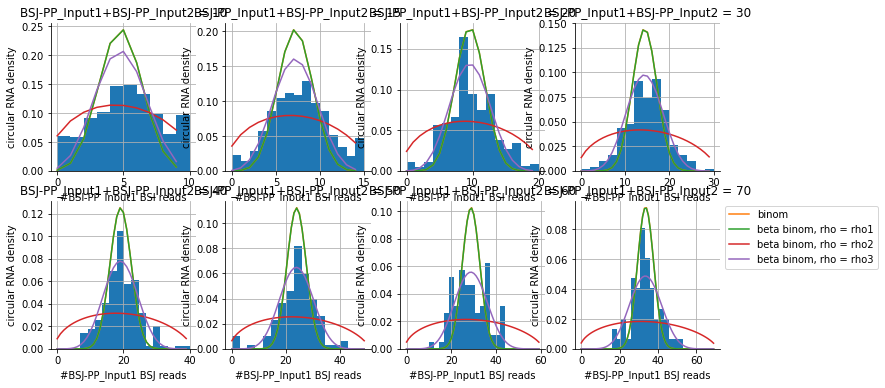

In [7]:
# ok plot it
import numpy as np
f, axes = plt.subplots(2,4, figsize = (12,6))
for cov, ax in zip([10,15,20,30,40,50,60,70,120], axes.flatten()):
    
    counts.loc[counts[[r1_handle, r2_handle]].sum(axis = 1)==cov, r1_handle].hist(
        ax = ax, density = True, bins = min(cov, 15))
    ax.set_title(f'{r1_handle}+{r2_handle} = {cov}')
    ax.set_xlabel(f'#{r1_handle} BSJ reads')
    ax.set_ylabel('circular RNA density')
    
    ax.plot(binom(cov, mu).pmf(np.arange(cov)), label = 'binom')
    
    alpha_bsj, beta_bsj = get_alpha_beta(mu, rho1) # rather arbitrary, betabinom did not figure out how to find coeff for rho despite zero=NULL
    bb_bsj=betabinom(cov, a=alpha_bsj, b = beta_bsj)
    ax.plot(bb_bsj.pmf(np.arange(cov)), label = 'beta binom, rho = rho1')
    
    
    
    alpha_bsj, beta_bsj = get_alpha_beta(mu, rho2) # rather arbitrary, betabinom did not figure out how to find coeff for rho despite zero=NULL
    bb_bsj=betabinom(cov, a=alpha_bsj, b = beta_bsj)
    ax.plot(bb_bsj.pmf(np.arange(cov)), label = 'beta binom, rho = rho2')
    
    alpha_bsj, beta_bsj = get_alpha_beta(mu, rho3) # rather arbitrary, betabinom did not figure out how to find coeff for rho despite zero=NULL
    bb_bsj=betabinom(cov, a=alpha_bsj, b = beta_bsj)
    ax.plot(bb_bsj.pmf(np.arange(cov)), label = 'beta binom, rho = rho3')
    
    
    
sns.despine()
ax.legend(bbox_to_anchor = (1,1))

# Judge model fit by QQ plot

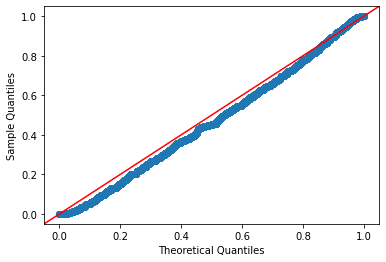

In [8]:
alpha_bsj, beta_bsj = get_alpha_beta(mu, rho3)
counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
counts[f'pvalue_null']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)


import statsmodels.api as sm
import scipy
p = sm.qqplot(counts.loc[counts['total_bsj']>10,f'pvalue_null'], line ='45',
             dist=scipy.stats.uniform)

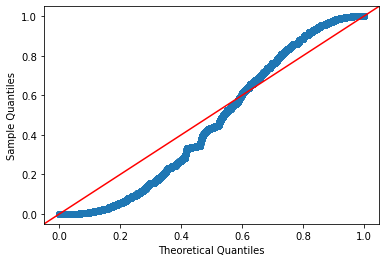

In [9]:
# as a contrast, binom p-value
counts[f'pvalue_binom']=counts.apply(lambda row: 1-binom(row['total_bsj'], mu).cdf(row[r1_handle]), axis =1)
p = sm.qqplot(counts.loc[counts['total_bsj']>10,f'pvalue_binom'], line ='45',
             dist=scipy.stats.uniform)
